In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import string
import pickle

from datetime import datetime
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

EMBED_DIM = 300
PRETRAINED_VEC = "/content/drive/MyDrive/CapstoneProject/NewVersion/glove.6B.300d.txt"

# 1. Utils

### 1.1 Helper Functions

In [ ]:
def timer(start_time=None):
  """ 
  Measure the block's execution time using the clock 
  """
  if not start_time:
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


def saveData(obj, filename_path):
  """
  file_type could be: .csv or .pickle
  """
  file_type = '.' + filename_path.split('.')[-1]
  if file_type == '.csv':
    obj.to_csv(filename_path, index=False)
  if file_type == '.pickle':
    with open(filename_path, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('Data saved successully.')


def loadData(filename_path):
  """
  file_type could be: .csv or .pickle
  """
  file_type = '.' + filename_path.split('.')[-1]
  if file_type == '.csv':
    obj = pd.read_csv(filename_path)
  if file_type == '.pickle':
    f = open(filename_path, 'rb')
    obj = pickle.load(f)
    f.close()
  return obj

### 1.2 Functions for Data Cleaning

In [ ]:
def extend(text):
  """ 
  Extend the abbreviations.
  """
  text = re.sub(r"won't", "will not", str(text))
  text = re.sub(r"can\'t", "can not", str(text))

  text = re.sub(r"n\'t", " not", str(text))
  text = re.sub(r"\'re", " are", str(text))
  text = re.sub(r"\'s", " is", str(text))
  text = re.sub(r"\'d", " would", str(text))
  text = re.sub(r"\'ll", " will", str(text))
  text = re.sub(r"\'t", " not", str(text))
  text = re.sub(r"\'ve", " have", str(text))
  text = re.sub(r"\'m", " am", str(text))
  return text


def removeHTML(text):
  """ 
  Removes HTML.
  """
  return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))','', str(text))


def removePuncLower(text):
  """
  Remove punctuation and change all letters to lower case
  """
  return ''.join(' ' if c in string.punctuation else c for c in str(text)).lower()


# https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
  """
  Remove all emoji.
  """
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)


def preprocess(corpus):
  """ 
  Cleans and removes unwanted characters from the corpus. 
  """
  preprocessed = list()
  for message in corpus:
    msg = removeHTML(message)
    msg = extend(msg)
    msg = removePuncLower(msg)
    msg = msg.replace('\\r', ' ')
    msg = msg.replace('\\"', ' ')
    msg = msg.replace('\\n', ' ')
    # clean numbers
    msg = re.sub('[0-9]+', ' ', str(msg))
    msg = ' '.join(msg.split())
    preprocessed.append(msg.strip())
  return preprocessed

### 1.3 Functions for get word-ID mapping

In [ ]:
def get_tokenizer(txt):
  """
  Vectorizing a text corpus
  """
  tokenizer = Tokenizer(filters='')
  tokenizer.fit_on_texts(txt)
  return tokenizer


def encode_pad_seq(tokenizer, length, txt):
  """
    Encode and pad sequences
  """
  # Integer encode sequences
  X = tokenizer.texts_to_sequences(txt)
  # Pad sequences with 0 values
  return pad_sequences(X, maxlen=length, padding='post')


def wordIDmapping(tokenizer):
  """
  Get both word-to-ID and ID-to-word mappings
  """
  vocab = tokenizer.word_index
  word2id = dict()
  id2word = dict()
  for k, v in vocab.items():
    word2id[k] = v
    id2word[v] = k
  return word2id, id2word


def tokenEmbed(tokenizer):
  """
  Use the pre-trained word-embedding vectors: “glove.6B.300d.text”
  Create token-embedding mapping
  """
  pretrained_vec = open(PRETRAINED_VEC)
  embeddings_index = dict()
  for i, line in enumerate(pretrained_vec):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

  vocab = tokenizer.word_index
  vocab_size = len(vocab) + 1
  embedding_matrix = np.zeros((vocab_size, EMBED_DIM))
  for word, i in vocab.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

# 2. Preprocess

In [ ]:
BASELINE_DATA = '/content/drive/MyDrive/CapstoneProject/NewVersion/single_qna.csv'
MODEL_DATA = '/content/drive/MyDrive/CapstoneProject/NewVersion/topical_chat.csv'

BASELINE_ROOT = '/content/drive/MyDrive/CapstoneProject/NewVersion/Baseline'
MODEL_ROOT = '/content/drive/MyDrive/CapstoneProject/NewVersion/MyModel'

ANS_LENGTH = 5

In [ ]:
baseline_data = loadData(BASELINE_DATA)
model_data = loadData(MODEL_DATA)

### 2.1 Preprocess baseline data

In [ ]:
baseline_data

,QuestionType,Asin,AnswerTime,UnixTime,Question,AnswerType,Answer,Category
0,yes/no,B00004U9JP,"Jun 27, 2014",1.403852e+09,I have a 9 year old Badger 1 that needs replac...,?,I replaced my old one with this without a hitch.,Appliances
1,open-ended,B00004U9JP,"Apr 28, 2014",1.398668e+09,model number,NaN,This may help InSinkErator Model BADGER-1: Bad...,Appliances
2,yes/no,B00004U9JP,"Aug 25, 2014",1.408950e+09,can I replace Badger 1 1/3 with a Badger 5 1/2...,?,Plumbing connections will vary with different ...,Appliances
3,yes/no,B00004U9JP,"Nov 3, 2014",1.415002e+09,Does this come with power cord and dishwasher ...,?,It does not come with a power cord. It does co...,Appliances
4,open-ended,B00004U9JP,"Jun 21, 2014",1.403334e+09,loud noise inside when turned on. sounds like ...,NaN,Check if you dropped something inside.Usually ...,Appliances
...,...,...,...,...,...,...,...,...
1396891,yes/no,B00KGGJPYA,"Nov 26, 2014",1.416989e+09,Does the adaptor cord for the iPhone 5 work wi...,N,No,Video Games
1396892,yes/no,B00KGGJPYA,"Oct 19, 2014",1.413702e+09,will it charge a kidle fire?,Y,"Simply answered, yes. It comes with a 3-in-1 a...",Video Games
1396893,open-ended,B00KGGJPYA,"Oct 15, 2014",1.413356e+09,What are the dimensions of this product?,NaN,4 by 1 1/2 inches,Video Games
1396894,yes/no,B00KGGJPYA,"Jul 15, 2014",1.405408e+09,Does this have connector for 5C? I think 5C is...,?,I was able to charge Gembonics battery with iP...,Video Games


In [ ]:
def removeCols(df):
  """
  Drop unecessary columns
  """
  df.drop('Asin', inplace=True, axis=1)
  df.drop('AnswerTime', inplace=True, axis=1)
  df.drop('UnixTime', inplace=True, axis=1)
  df.drop('Category', inplace=True, axis=1)
  df.drop('AnswerType', inplace=True, axis=1)
  
  df.dropna()
  df.reset_index(drop=True, inplace=True)
  return df


def addLengthCol(df):
  """
  Process Dataframe
  """
  df.dropna()
  df['Question'] = preprocess(df['Question'])
  df['Answer'] = preprocess(df['Answer'])
  df.drop_duplicates(inplace=True)
  df.dropna()
  df.reset_index(drop=True, inplace=True)

  # add QA length
  df['QuestionLength'] = df['Question'].str.split().apply(len)
  df['AnswerLength'] = df['Answer'].str.split().apply(len)

  # remove QA with length 0
  df = df[df['AnswerLength'] > 0]
  df = df[df['QuestionLength'] > 0]
  df.reset_index(drop=True, inplace=True)
  return df


def restrictLength(df, Anslength):
  """
  Resctrict the Questions and Answers length
  - Questions length <= mean length
  - Answers length <= Anslength
  """
  Qlength = int(df['QuestionLength'].mean())
  df = df[df["QuestionLength"] <= Qlength]
  df.reset_index(drop=True, inplace=True)
  df = df[df['AnswerLength'] <= Anslength]
  df.reset_index(drop=True, inplace=True)
  # add begin & end indicators to answers, add QA column
  df['Answer'] = df['Answer'].apply(lambda x : '<bos> '+ str(x) + ' <eos>')
  df['QA'] = df['Question'].astype(str) + ' ' + df['Answer'].astype(str)
  return df


def processDataframe(df, DATASET_TYPE):
  """
  Further process the datasets
  """
  if DATASET_TYPE == 'BASELINE':
    df = removeCols(df)
    df = addLengthCol(df)
    df = restrictLength(df, ANS_LENGTH)
  if DATASET_TYPE == 'MODEL':
    df.message = preprocess(df.message)
    df.dropna()
    df.drop('sentiment', inplace=True, axis=1)
    df.reset_index(drop=True, inplace=True)
  return df

In [ ]:
baseline_df = processDataframe(baseline_data, 'BASELINE')
baseline_df

,QuestionType,Question,Answer,QuestionLength,AnswerLength,QA
0,open-ended,where is the reset button located,<bos> on the bottom <eos>,6,3,where is the reset button located <bos> on the...
1,yes/no,is there a connection for the dish washer,<bos> yes <eos>,8,1,is there a connection for the dish washer <bos...
2,yes/no,does this test forlead,<bos> yes it does <eos>,4,3,does this test forlead <bos> yes it does <eos>
3,yes/no,does it work with kenmore humidifier,<bos> yes it does <eos>,6,3,does it work with kenmore humidifier <bos> yes...
4,yes/no,does this filter fit the holmes hm,<bos> yes <eos>,7,1,does this filter fit the holmes hm <bos> yes <...
...,...,...,...,...,...,...
148399,yes/no,can you play the tomodachi life on a regular n...,<bos> no ds only <eos>,11,3,can you play the tomodachi life on a regular n...
148400,yes/no,is this like sims,<bos> sure is <eos>,4,2,is this like sims <bos> sure is <eos>
148401,open-ended,is this a hard copy or a download,<bos> hard copy <eos>,8,2,is this a hard copy or a download <bos> hard c...
148402,yes/no,does it play blue ray movies,<bos> yes <eos>,6,1,does it play blue ray movies <bos> yes <eos>


In [ ]:
# filname = '/processed_clean_single_qna.csv'
# saveData(baseline_df, BASELINE_ROOT + filname)

### 2.2 Preprocess model data

In [ ]:
model_data = loadData(MODEL_DATA)

In [ ]:
model_data

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper
...,...,...,...
188373,8628,"Wow, it does not seem like that long. Since I...",Surprised
188374,8628,"I havent seen that episode, I might google it...",Curious to dive deeper
188375,8628,I don't think I have either. That's an insane...,Curious to dive deeper
188376,8628,"I did, my little brother used to love Thomas ...",Happy


In [ ]:
model_df = processDataframe(model_data, 'MODEL')
model_df

,conversation_id,message
0,1,are you a fan of google or microsoft
1,1,both are excellent technology they are helpful...
2,1,i am not a huge fan of google but i use it a l...
3,1,google provides online related services and pr...
4,1,yeah their services are good i am just not a f...
...,...,...
188373,8628,wow it does not seem like that long since i me...
188374,8628,i havent seen that episode i might google it l...
188375,8628,i do not think i have either that is an insane...
188376,8628,i did my little brother used to love thomas th...


In [ ]:
# filname = '/cleaned_topical_chat.csv'
# saveData(model_df, MODEL_ROOT + filname)

In [ ]:
def vectorization(df):
  """
  Vectorize the data and split out the input and target texts.
  """
  input_texts = []
  target_texts = []
  input_words_set = set()
  target_words_set = set()
  for conversation_index in tqdm(range(df.shape[0])):
    if conversation_index == 0:
      continue
    input_text = df.iloc[conversation_index - 1]
    target_text = df.iloc[conversation_index]
    if input_text.conversation_id == target_text.conversation_id:
      input_text = input_text.message
      target_text = target_text.message
      if input_text and target_text and len(input_text.split()) in range(3, 30) and len(target_text.split()) in range(1, 10):
        # Add <bos> and <eos> indicators to the target_text
        target_text = '<bos> ' + target_text + ' <eos>'         
        input_texts.append(input_text)
        target_texts.append(target_text)
        for word in input_text.split():
          if word not in input_words_set:
            input_words_set.add(word)
        for word in target_text.split():
          if word not in target_words_set:
            target_words_set.add(word)
  return input_texts, target_texts, input_words_set, target_words_set


def saveVectorizationResult(df, root):
  """
  Save the vectorization result.
  """
  input_texts, target_texts, input_words_set, target_words_set = vectorization(df)
  fname1, fname2, fname3, fname4 = '/input_texts.pickle', '/target_texts.pickle', '/input_words_set.pickle', '/target_words_set.pickle'
  saveData(input_texts, root + fname1)
  saveData(target_texts, root + fname2)
  saveData(input_words_set, root + fname3)
  saveData(target_words_set, root + fname4)
  return input_texts, target_texts, input_words_set, target_words_set

In [ ]:
root = '/content/drive/MyDrive/CapstoneProject/NewVersion/MyModel'
input_texts, target_texts, input_words_set, target_words_set = saveVectorizationResult(model_df, root)

100%|██████████| 188378/188378 [00:40<00:00, 4614.77it/s]


Data saved successully.
Data saved successully.
Data saved successully.
Data saved successully.


In [ ]:
len(input_texts), len(target_texts), len(input_words_set), len(target_words_set)

(19868, 19868, 11438, 7022)

# 3. Vectorization (Tokenization), Padding

### 3.1 Baseline dataset

In [ ]:
SEED = 42
# X = (Question, QA), y = Answer; train:validation = 8:2
enc_train, enc_test, qa_train, qa_test, dec_train, dec_test = train_test_split(baseline_df['Question'], baseline_df['QA'], baseline_df['Answer'], test_size=0.005, random_state=SEED)
enc_train, enc_val, qa_train, qa_val, dec_train, dec_val = train_test_split(enc_train, qa_train, dec_train, test_size=0.2, random_state=SEED)
qa_tokenizer = get_tokenizer(baseline_df['QA'])

enc_train = encode_pad_seq(qa_tokenizer, baseline_df['QuestionLength'].max(), enc_train)
enc_val = encode_pad_seq(qa_tokenizer, baseline_df['QuestionLength'].max(), enc_val)
enc_test = encode_pad_seq(qa_tokenizer, baseline_df['QuestionLength'].max(), enc_test)
# Answer Length + 2 for '<bos>' and '<eos>'
dec_train = encode_pad_seq(qa_tokenizer, baseline_df['AnswerLength'].max()+2, dec_train)
dec_val = encode_pad_seq(qa_tokenizer, baseline_df['AnswerLength'].max()+2, dec_val)
dec_test = encode_pad_seq(qa_tokenizer, baseline_df['AnswerLength'].max()+2, dec_test)

In [ ]:
# # Save Data
# saveData(qa_tokenizer, BASELINE_ROOT + '/qa_tokenizer.pickle')

# saveData(enc_train, BASELINE_ROOT + '/enc_train.pickle')
# saveData(enc_val, BASELINE_ROOT + '/enc_val.pickle')
# saveData(enc_test, BASELINE_ROOT + '/enc_test.pickle')

# saveData(dec_train, BASELINE_ROOT + '/dec_train.pickle')
# saveData(dec_val, BASELINE_ROOT + '/dec_val.pickle')
# saveData(dec_test, BASELINE_ROOT + '/dec_test.pickle')

In [ ]:
embedding_matrix = tokenEmbed(qa_tokenizer)
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.090649  , -0.033193  ,  0.54229999, ..., -0.23192   ,
        -0.57389998,  0.25735   ],
       [ 0.027796  , -0.20241   ,  0.23388   , ..., -0.105     ,
         0.26631001,  0.60374999]])

In [ ]:
embedding_matrix.shape

(31973, 300)

### 3.2 Model dataset

In [ ]:
input_tokenizer, target_tokenizer = get_tokenizer(input_texts), get_tokenizer(target_texts)
input_maxlen, target_maxlen = max([len(x) for x in input_texts]), max([len(x) for x in target_texts])
input_sequences = encode_pad_seq(input_tokenizer, input_maxlen, input_texts)
target_sequences = encode_pad_seq(target_tokenizer, target_maxlen, target_texts)

In [ ]:
# # Save Data
# saveData(input_sequences, MODEL_ROOT + '/input_sequences.pickle')
# saveData(target_sequences, MODEL_ROOT + '/target_sequences.pickle')

# 4. My Model

### 4.1 My model clustering

In [ ]:
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 23.1 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=388743 sha256=ff1f4f79a916b3ef8651594a9454f87cc912dcbac3ae7cceb53337cb506d4de5
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 27.6 MB/s 


In [ ]:
from annoy import AnnoyIndex
import random

NUM_TREES = 100
NUM_NN = 10
CONVERSATION_ID = 428  # query: 'do you enjoy movies'; ANS: 'yes i do do you'

In [ ]:
def remove_indicator(msg):
    msg = msg.replace('<bos>', '')
    msg = msg.replace('<eos>', '')
    return msg.strip()

def annoyID(sequences, fname):
  annoy = AnnoyIndex(sequences.shape[1], 'angular')  # Length of item vector that will be indexed
  for i, row in enumerate(sequences):
      annoy.add_item(i, row)

  annoy.build(NUM_TREES) # 100 trees
  annoy.save(MODEL_ROOT + fname)


def test_NN(annoy_fname, conversationID, texts):
  annoy = AnnoyIndex(max([len(x) for x in texts]), 'angular')
  annoy.load(annoy_fname)
  neighbor_id, dist = annoy.get_nns_by_item(conversationID, NUM_NN, include_distances=True)

  print(remove_indicator(texts[conversationID]))
  print("\n############### Nearest Neighbours ###############\n")
  for i in range(len(neighbor_id)):
      print(remove_indicator(texts[neighbor_id[i]]), "--------- neighbor_index -", neighbor_id[i], ", distance -", dist[i])

In [ ]:
# annoyID(input_sequences, '/my_model_input_annoy.ann')
# annoyID(target_sequences, '/my_model_target_annoy.ann')

In [ ]:
def sim_matrix(texts, annoy_fname):
  texts_len, max_input_len = len(texts), max([len(x) for x in texts])
  sim_matrix = (-1) * np.ones((texts_len, texts_len), dtype=int)
  annoy = AnnoyIndex(max_input_len, 'angular')
  annoy.load(annoy_fname)

  for i in tqdm(range(texts_len)):
    neighbor_id, dist = annoy.get_nns_by_item(i, texts_len, include_distances=True)
    input_sim_row = (-1) * np.ones((texts_len, ), dtype=int)
    for j in range(texts_len):
        input_sim_row[neighbor_id[j]] = dist[j]
    sim_matrix[i, :] = input_sim_row.T
  return sim_matrix

In [ ]:
# input_sim_matrix = sim_matrix(input_texts, MODEL_ROOT + '/my_model_input_annoy.ann')
# target_sim_matrix = sim_matrix(target_texts, MODEL_ROOT + '/my_model_target_annoy.ann')
# saveData(input_sim_matrix, MODEL_ROOT + '/input_sim_matrix.pickle')
# saveData(input_sim_matrix, MODEL_ROOT + '/target_sim_matrix.pickle')

In [ ]:
# read out the similarity matrix
input_sim_matrix = loadData(MODEL_ROOT + '/input_sim_matrix.pickle')
target_sim_matrix = loadData(MODEL_ROOT + '/target_sim_matrix.pickle')

In [ ]:
input_sim_matrix.shape, target_sim_matrix.shape

((19868, 19868), (19868, 19868))

In [ ]:
input_sim_df = pd.DataFrame(input_sim_matrix, columns = range(input_sim_matrix.shape[1]))
target_sim_df = pd.DataFrame(target_sim_matrix, columns = range(target_sim_matrix.shape[1]))

In [ ]:
input_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19858,19859,19860,19861,19862,19863,19864,19865,19866,19867
0,0.000000,1.344295,1.331164,1.270827,1.254641,1.380180,1.350131,1.357583,1.361789,1.360375,...,1.385236,1.331304,1.392079,1.365885,1.327376,1.273507,0.964341,1.403390,1.350560,1.129817
1,1.344295,0.000000,1.362493,1.326461,1.390804,1.411008,0.320509,1.336462,1.392442,1.382465,...,1.369960,1.230481,1.313893,1.303629,1.342396,1.408235,1.327577,1.407427,0.974667,1.392829
2,1.331164,1.362493,0.000000,1.166142,1.155873,1.394250,1.379086,0.982278,1.051386,1.300136,...,1.405601,1.116503,1.382034,1.106163,1.366550,1.375227,1.052437,1.376224,1.128506,1.100415
3,1.270827,1.326461,1.166142,0.000228,0.482207,1.411017,1.375087,1.399945,1.186872,1.234696,...,1.403653,1.165296,1.295896,1.316020,1.391491,1.355694,1.339058,1.357546,1.347465,1.333163
4,1.254641,1.390804,1.155873,0.482207,0.000148,1.411858,1.384912,1.400951,1.297333,1.246686,...,1.386630,1.309996,1.325572,1.388492,1.401903,1.346565,1.384899,1.399921,1.382753,1.394877


In [ ]:
target_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19858,19859,19860,19861,19862,19863,19864,19865,19866,19867
0,0.000000,1.395294,1.314090,1.402868,0.936675,0.993378,1.299375,0.741674,1.396984,1.383108,...,0.683433,0.947182,1.357449,0.636633,1.236617,1.343532,1.393998,1.216092,1.292499,1.354045
1,1.395294,0.000078,0.668846,1.012590,1.343000,1.382488,1.329733,1.294523,0.901328,0.699525,...,1.392895,1.390858,1.002385,1.392864,1.387762,1.327270,1.385113,0.993468,1.352092,1.003284
2,1.314090,0.668846,0.000000,0.550645,1.151856,1.338852,1.353056,1.271084,1.321147,1.169441,...,1.391805,1.248804,0.541768,1.370588,1.334592,1.331683,1.408666,1.352387,1.320658,0.570481
3,1.402868,1.012590,0.550645,0.000372,1.281089,1.373845,1.385990,1.325520,1.360449,1.352397,...,1.410739,1.384099,0.134449,1.395890,1.401921,1.397002,1.406615,1.404872,1.357431,0.335288
4,0.936675,1.343000,1.151856,1.281089,0.000000,1.102362,1.315354,1.383337,1.397650,1.341768,...,1.408415,0.164817,1.271491,1.366058,1.181326,1.373083,1.302003,1.366934,1.147282,1.244243


In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter
N_NEIGHBOR = 10

In [ ]:
def find_eps_nums(sim_matrix):
  eps_nums = list()
  eps_num_clusters = list()
  eps_num_noise = list()
  trial_eps = np.linspace(0, 0.03, num=50)

  for eps_num in trial_eps:
      if eps_num > 0:   
          print("Taking EPS as", eps_num)
          # Compute DBSCAN
          db = DBSCAN(eps=eps_num, min_samples=2, metric="precomputed", n_jobs=4).fit(sim_matrix)
          labels = db.labels_

          # Number of clusters in labels, ignoring noise if present.
          n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
          n_noise_ = list(labels).count(-1)

          eps_nums.append(eps_num)
          eps_num_clusters.append(n_clusters_)
          eps_num_noise.append(n_noise_)

          print('Estimated number of clusters: %d' % n_clusters_)
          print('Estimated number of noise points: %d' % n_noise_)
          print("-----------")
          
          if n_clusters_ == 1:
              break

  # plot the image for visualization
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.set_xlabel('eps')
  ax1.set_ylabel('number of clusters', color=color)
  ax1.plot(eps_nums, eps_num_clusters, color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()

  ax2.plot(eps_nums, eps_num_noise)
  ax2.set_ylabel('noise')
  plt.show()

Taking EPS as 0.0006122448979591836
Estimated number of clusters: 773
Estimated number of noise points: 16241
-----------
Taking EPS as 0.0012244897959183673
Estimated number of clusters: 789
Estimated number of noise points: 16158
-----------
Taking EPS as 0.001836734693877551
Estimated number of clusters: 802
Estimated number of noise points: 16094
-----------
Taking EPS as 0.0024489795918367346
Estimated number of clusters: 808
Estimated number of noise points: 16032
-----------
Taking EPS as 0.003061224489795918
Estimated number of clusters: 806
Estimated number of noise points: 15978
-----------
Taking EPS as 0.003673469387755102
Estimated number of clusters: 808
Estimated number of noise points: 15936
-----------
Taking EPS as 0.004285714285714285
Estimated number of clusters: 816
Estimated number of noise points: 15887
-----------
Taking EPS as 0.004897959183673469
Estimated number of clusters: 814
Estimated number of noise points: 15844
-----------
Taking EPS as 0.0055102040816

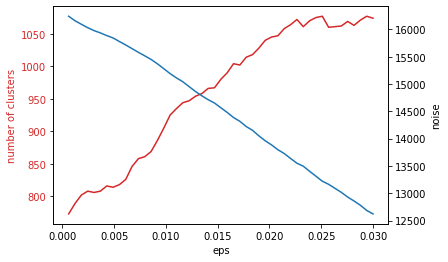

In [ ]:
find_eps_nums(target_sim_matrix)

In [ ]:
def dbscan(eps_num, sim_matrix, texts):
  # eps_num = 0.01  # eps_num = 0.01 with 913 clusters
  print("Taking EPS as", eps_num)
  # Compute DBSCAN
  db = DBSCAN(eps=eps_num, min_samples=2, metric="precomputed", n_jobs=4).fit(sim_matrix)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_

  # Number of clusters in labels, ignoring noise if present.
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise = list(labels).count(-1)

  print('Estimated number of clusters: %d' % n_clusters)
  print('Estimated number of noise points: %d' % n_noise)

  for unique_label in set(labels):
    class_member_mask = (labels == unique_label)
    vec_func = np.vectorize(remove_indicator)
    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(vec_func(np.array(texts)[class_member_mask]))
    print("-------------------------------------")
  
  return db, n_clusters

In [ ]:
eps_num = 0.008
db, n_clusters = dbscan(eps_num, target_sim_matrix, target_texts)

In [ ]:
eps_num = 0.008  # eps_num = 0.01 with 913 clusters
print("Taking EPS as", eps_num)
# Compute DBSCAN
db0 = DBSCAN(eps=eps_num, min_samples=2, metric="precomputed", n_jobs=4).fit(target_sim_matrix)
core_samples_mask = np.zeros_like(db0.labels_, dtype=bool)
core_samples_mask[db0.core_sample_indices_] = True
labels = db0.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

for unique_label in set(labels):
  class_member_mask = (labels == unique_label)
  vec_func = np.vectorize(remove_indicator)
  print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
  print("Samples")
  print(vec_func(np.array(target_texts)[class_member_mask]))
  print("-------------------------------------")

Taking EPS as 0.008
Estimated number of clusters: 859
Estimated number of noise points: 15513
In cluster 0 found 47 points
Samples
['nice do you like shakespeare' 'yeah do you like shakespeare'
 'nice do you like soundtracks' 'yes do you like pixar'
 'do you know the results' 'yeah do you like spiderman'
 'yes do you like politics' 'is not he a composer'
 'yes do you like guitars' 'wow that is really massive'
 'yeah do you like eminem' 'i did not see bp did you'
 'do you like the temptations' 'no what do they dispense'
 'that they have a preference' 'yes i love the yt are you'
 'i did not interesting trivia' 'are you talking about piper'
 'yeah do you like softball' 'yes do you like literature'
 'do you have a cimputer' 'yeah do you like playstation'
 'i think it was mill' 'did you ever play turok'
 'nice do you like dancing' 'i know i was shocked'
 'nice do you like jeans' 'that is interesting to hedar why is that'
 'i love to watch sitcoms what about you' 'it is a interesting subject

### 4.2 My model training

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
len(input_texts), len(db0.labels_), db0.labels_.shape

(19868, 19868, (19868,))

In [ ]:
len(input_sequences), len(target_sequences)

(19868, 19868)

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.9.2


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts)
total_words = len(tokenizer.word_index) + 1
input_tokens = tokenizer.texts_to_sequences(input_texts)

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    return input_sequences, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(input_tokens)

In [ ]:
labels = np.array(db0.labels_, copy=True)
labels[labels == -1] = len(set(db0.labels_)) - 1
print(labels[:10])

[859 859 859   0 859 859 859 859 859 859]


In [ ]:
encoder_labels = OneHotEncoder().fit(labels.reshape(-1, 1))
one_hot_labels = encoder_labels.transform(labels.reshape(-1, 1))
one_hot_labels.shape

(19868, 860)

In [ ]:
def create_model(max_sequence_len, total_words):
    # input_len = max_sequence_len - 1
    input_len = max_sequence_len
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Embedding(total_words, 512, input_length=input_len),
            tf.keras.layers.LSTM(512),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(one_hot_labels.shape[1], activation='softmax')
        ]
    )
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model


with strategy.scope():
    model = create_model(max_sequence_len, total_words)
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 29, 512)           5856768   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 860)               441180    
                                                                 
Total params: 8,397,148
Trainable params: 8,397,148
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(predictors, one_hot_labels.todense(), epochs=25, verbose=1)

Epoch 1/25
621/621 [==============================] - 285s 454ms/step - loss: 1.8826 - accuracy: 0.7795
Epoch 2/25
621/621 [==============================] - 259s 417ms/step - loss: 1.6687 - accuracy: 0.7817
Epoch 3/25
621/621 [==============================] - 257s 413ms/step - loss: 1.5541 - accuracy: 0.7830
Epoch 4/25
621/621 [==============================] - 255s 410ms/step - loss: 1.4331 - accuracy: 0.7850
Epoch 5/25
621/621 [==============================] - 255s 411ms/step - loss: 1.2912 - accuracy: 0.7888
Epoch 6/25
621/621 [==============================] - 257s 413ms/step - loss: 1.1409 - accuracy: 0.7932
Epoch 7/25
621/621 [==============================] - 256s 413ms/step - loss: 0.9795 - accuracy: 0.8044
Epoch 8/25
621/621 [==============================] - 255s 410ms/step - loss: 0.8089 - accuracy: 0.8224
Epoch 9/25
621/621 [==============================] - 255s 411ms/step - loss: 0.6408 - accuracy: 0.8513
Epoch 10/25
621/621 [==============================] - 256s 413m

In [ ]:
# Save model
model.save(MODEL_ROOT + "/my_model_lstm.hdf5")

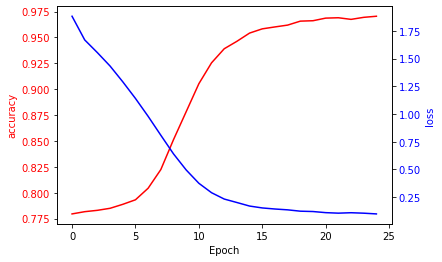

In [ ]:
EPOCH = 25
# plot the image for visualization
fig, ax1 = plt.subplots()
color1, color2 = 'r', 'b'
ax1.set_xlabel('Epoch')

ax1.set_ylabel('accuracy', color=color1)
ax1.plot(range(EPOCH), history.history['accuracy'], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel('loss', color=color2)
ax2.plot(range(EPOCH), history.history['loss'], color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.show()

### 4.3 My model inference

In [ ]:
def get_responses(seed_text, n):
    print("Input -", seed_text)
    print("----------------------")
    responses = list()
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
    with strategy.scope():
        predictions = model.predict(token_list, verbose=10)
        predicted_indices = predictions.argsort()[0][::-1][:n]
        print(predicted_indices)
    
    for predicted_index in predicted_indices:
        score = 0
        if predicted_index == len(set(db0.labels_)) - 1:
            print("Predicting outside clusters")
            predicted_index = -1
        else:
            score = predictions[0][predicted_index]
            
        # randomly pick 1 index
        possible_response = np.where(db0.labels_==predicted_index)[0]
        response_index = random.sample(possible_response.tolist(), 1)[0]
        responses.append([target_texts[response_index].replace("\t", "").replace("\n", ""), score])


    for i, response in enumerate(responses):
        print("Response", (i + 1), "->", remove_indicator(response[0]), " -> Score :", response[1])

In [ ]:
get_responses("goodbye", 5)

Input - goodbye
----------------------
[  1 287  11 146  26]
Response 1 -> bye  -> Score : 0.80293936
Response 2 -> you too bye  -> Score : 0.09088175
Response 3 -> you too  -> Score : 0.03483983
Response 4 -> see ya  -> Score : 0.007316481
Response 5 -> have a good one  -> Score : 0.006519781


In [ ]:
print(input_texts.index('do you like comic books'))
print(input_texts.index('have a good evening'))
print(input_texts.index('hi how are you'))
print(input_texts.index('do you know much about the bible'))

19
70
74
109


In [ ]:
get_responses(input_texts[19], 5)

Input - do you like comic books
----------------------
[859   1  68 176 137]
Predicting outside clusters
Response 1 -> i dont really know wrestling do you like it  -> Score : 0
Response 2 -> bye  -> Score : 0.00065130764
Response 3 -> and japan  -> Score : 0.00050498196
Response 4 -> i do do you  -> Score : 0.0003659675
Response 5 -> yes i do  -> Score : 0.00026389974


In [ ]:
get_responses(input_texts[70], 5)

Input - have a good evening
----------------------
[143  11  21   3 859]
Predicting outside clusters
Response 1 -> you too thanks  -> Score : 0.35637453
Response 2 -> you too  -> Score : 0.2833359
Response 3 -> thanks you too  -> Score : 0.117094755
Response 4 -> you as well  -> Score : 0.07854869
Response 5 -> you bet it is been a pleasure  -> Score : 0


In [ ]:
get_responses(input_texts[74], 5)

Input - hi how are you
----------------------
[859  76 168 165 292]
Predicting outside clusters
Response 1 -> not much but there are funny facts about politics  -> Score : 0
Response 2 -> i am great how are you  -> Score : 0.025159404
Response 3 -> fine what about you  -> Score : 0.014521872
Response 4 -> i am doing great how are you doing tonight  -> Score : 0.0143528925
Response 5 -> good how are you  -> Score : 0.009759976


In [ ]:
get_responses(input_texts[109], 5)

Input - do you know much about the bible
----------------------
[ 17 859 540 812   0]
Predicting outside clusters
Response 1 -> hi good  -> Score : 0.9866679
Response 2 -> are you referring to the big bang  -> Score : 0
Response 3 -> not really you  -> Score : 0.00011273302
Response 4 -> yes the website that exposes government secrets  -> Score : 9.960673e-05
Response 5 -> nice do you like soundtracks  -> Score : 9.716303e-05
